## Helper function

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import torch

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [9]:
def generate_circular_data(n_points, noise=0.0):
    """
    Generate data on a circular 2D manifold embedded in 3D space with added noise.
    :param n_points: Number of points to sample.
    :param noise: Standard deviation of Gaussian noise added to x, y, and z dimensions.
    :return: Points on the circular manifold as an (n_points, 3) array.
    """
    # Uniform sampling of theta (angle around the circle)
    theta = np.linspace(0, 2 * np.pi, n_points)
    
    # Parametric equations for a circle in 3D
    x = np.cos(theta)  # x-coordinate on the circle
    y = np.sin(theta)  # y-coordinate on the circle
    z = np.random.uniform(-5, 5, n_points)  # z-coordinate (height)

    # Add Gaussian noise to the x and y coordinates
    if noise > 0:
        x += noise * np.random.randn(n_points)
        y += noise * np.random.randn(n_points)
        z += noise * np.random.randn(n_points)  # Noise in the z-dimension

    points = np.column_stack((x, y, z))
    
    return points

In [10]:
# Example usage
n_points = 1000
noise = 0.1
np.random.seed(1)
circular_data = generate_circular_data(n_points, noise=noise)

# Convert to PyTorch tensor
circular_data_tensor = torch.tensor(circular_data, dtype=torch.float32)

# Create DataLoader for batching
dataset = TensorDataset(circular_data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

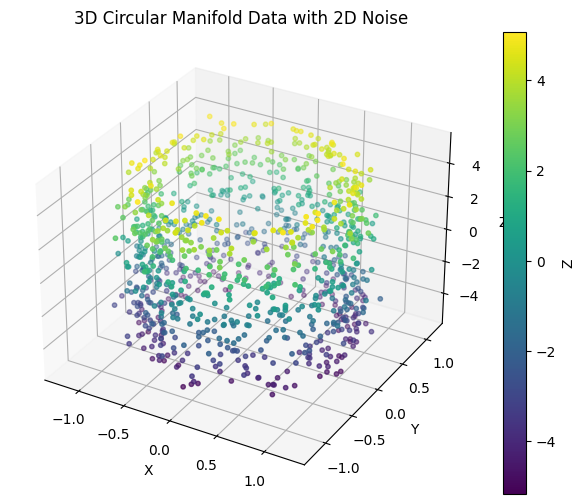

In [11]:
# Visualize the generated circular data
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    circular_data[:, 0], circular_data[:, 1], circular_data[:, 2], 
    c=circular_data[:, 2], cmap='viridis', s=10
)
ax.set_title("3D Circular Manifold Data with 2D Noise")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(scatter, label='Z')
plt.show()

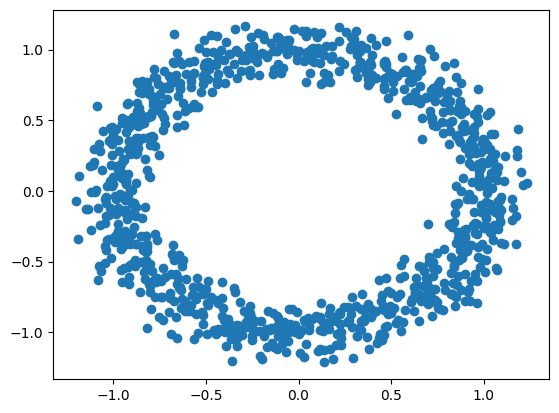

In [12]:
plt.scatter(circular_data[:, 0], circular_data[:, 1])
plt.savefig("figures/circular_plots/2d_mani.png", format="png")

## Train VAE 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder: 3D to 2D latent space
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3_mean = nn.Linear(5, latent_dim)
        self.fc3_log_var = nn.Linear(5, latent_dim)
        
        # Decoder: 2D to 3D
        self.fc4 = nn.Linear(latent_dim, 5)
        self.fc5 = nn.Linear(5, 10)
        self.fc6 = nn.Linear(10, input_dim)
        
    def encode(self, x):
        # h = self.activation(self.fc1(x))
        # h = self.activation(self.fc2(h))
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        z_mean = self.fc3_mean(h)
        z_log_var = self.fc3_log_var(h)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std
    
    def decode(self, z):
        # h = self.activation(self.fc4(z))
        # h = self.activation(self.fc5(h))
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        return self.fc6(h)
    
    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        return self.decode(z), z_mean, z_log_var

# Flattening Regularization Function
def flattening_regularization(vae, z):
    """
    Adds flattening regularization on the decoder's Jacobian to make it close to the identity matrix.
    The Jacobian of the decoder is computed as the gradient of the output w.r.t. the latent space.
    """
    z.requires_grad_(True)
    decoder_output = vae.decode(z)
    
    # Compute Jacobian matrix (gradient of decoder output with respect to z)
    jacobian = torch.autograd.grad(decoder_output, z, grad_outputs=torch.ones_like(decoder_output), create_graph=True)[0]
    
    # Compute J^T J and enforce it to be close to the identity matrix
    JtJ = torch.matmul(jacobian.T, jacobian)
    
    # Regularization term is the Frobenius norm of J^T J - I (identity matrix)
    identity_matrix = torch.eye(JtJ.size(0), device=JtJ.device)
    regularization_term = torch.norm(JtJ - identity_matrix, p='fro')
    
    return regularization_term

# Define the VAE loss function: reconstruction loss + KL divergence + flattening regularization (optional)
def vae_loss(recon_x, x, z_mean, z_log_var, vae, z, lambda_flatten=1.0, use_flattening=False):
    reconstruction_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    # kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    # loss = reconstruction_loss +  kl_loss
    loss = reconstruction_loss
    
    # Apply flattening regularization if specified
    if use_flattening:
        flattening_loss = flattening_regularization(vae, z)
        loss += lambda_flatten * flattening_loss
    
    return loss

In [14]:
# Instantiate the model, optimizer
latent_dim = 2  # Latent space dimension
input_dim = circular_data.shape[1]  # 3D input
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-2)

# Training the VAE with flattening regularization (set use_flattening to True or False)
use_flattening = True  # Set this to False to train a normal VAE (without regularization)
lambda_flatten = 2  # Regularization strength

# # Training the VAE
# epochs = 1000
# for epoch in range(epochs):
#     vae.train()
#     train_loss = 0
#     for batch in dataloader:
#         x_batch = batch[0]
        
#         optimizer.zero_grad()
        
#         recon_batch, z_mean, z_log_var = vae(x_batch)
#         z = vae.reparameterize(z_mean, z_log_var)
        
#         loss = vae_loss(recon_batch, x_batch, z_mean, z_log_var, vae, z, lambda_flatten, use_flattening)
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
    
#     print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(dataloader)}')

# # Visualize the latent space (2D representation)
# vae.eval()
# with torch.no_grad():
#     z_mean_encoded, _ = vae.encode(circular_data_tensor)
    
# plt.figure(figsize=(8, 6))
# plt.scatter(z_mean_encoded[:, 0], z_mean_encoded[:, 1], c=circular_data[:, 2], cmap='viridis', s=10)
# plt.colorbar(label='z-axis value (color)')
# plt.title("2D Latent Space of Swiss Roll")
# plt.xlabel("Latent Dimension 1")
# plt.ylabel("Latent Dimension 2")
# plt.show()

# # Visualize original vs reconstructed 3D Swiss Roll
# with torch.no_grad():
#     reconstructed = vae.decode(z_mean_encoded).numpy()

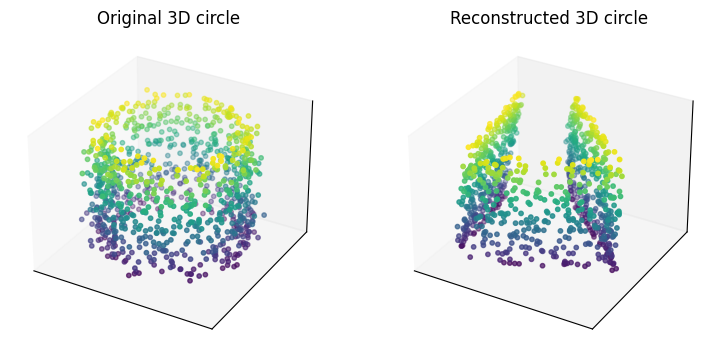

In [77]:
fig = plt.figure(figsize=(9, 9))

# Original 3D circle plot
ax = fig.add_subplot(121, projection='3d')
ax.scatter(circular_data[:, 0], circular_data[:, 1], circular_data[:, 2], 
           c=circular_data[:, 2], cmap='viridis', s=10)
ax.set_title("Original 3D circle")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Reconstructed 3D circle plot
ax = fig.add_subplot(122, projection='3d')
ax.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], 
           c=circular_data[:, 2], cmap='viridis', s=10)
ax.set_title("Reconstructed 3D circle")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.savefig("figures/circular_plots/reconstruction_0.png", format="png")

plt.show()

# Interpolate and decode

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function for linear latent space interpolation and decoding
@torch.no_grad()
def interpolate_and_decode(vae, start_idx, end_idx, circular_data, path, num_steps=10):
    # Encode the start and end points
    start_point = circular_data[start_idx:start_idx+1]
    end_point = circular_data[end_idx:end_idx+1]
    
    # Pass the points through the encoder to get their latent codes
    z_start_mean, _ = vae.encode(torch.tensor(start_point, dtype=torch.float32))
    z_end_mean, _ = vae.encode(torch.tensor(end_point, dtype=torch.float32))
    
    # Linear interpolation between the two latent codes
    interpolation = np.linspace(0, 1, num_steps)
    
    interpolated_latents = []
    for alpha in interpolation:
        z_interp = alpha * z_end_mean + (1 - alpha) * z_start_mean
        interpolated_latents.append(z_interp.numpy())
    
    interpolated_latents = np.array(interpolated_latents)
    
    # Decode the interpolated latent codes
    decoded_points = vae.decode(torch.tensor(interpolated_latents, dtype=torch.float32)).detach().numpy().squeeze()
    
    # Plot the interpolation in the 2D Swiss Roll space (x, y)
    plt.figure(figsize=(4,3))
    scatter = plt.scatter(
        circular_data[:, 0], 
        circular_data[:, 1], 
        c=circular_data[:, 2], 
        cmap='viridis', 
        s=10, 
        label='Original Data'
    )
    plt.plot(
        decoded_points[:, 0], 
        decoded_points[:, 1], 
        marker='o', 
        color='red', 
        label='Interpolated Path', 
        linestyle='--', 
        markersize=0.5
    )
    # plt.title("Latent Space Interpolation (Path in the Swiss Roll)", fontsize=10)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(scatter, label='Z')
    
    # Adjust the legend position to be outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

54 364


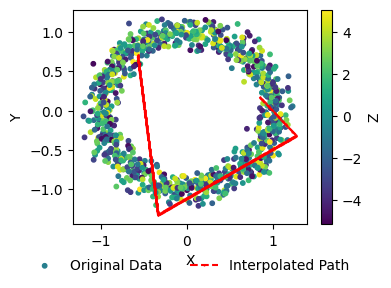

472 118


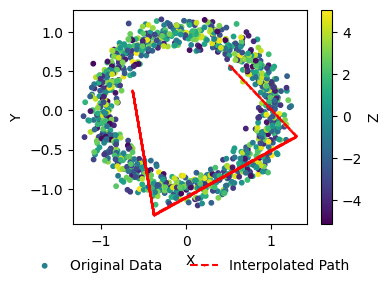

291 475


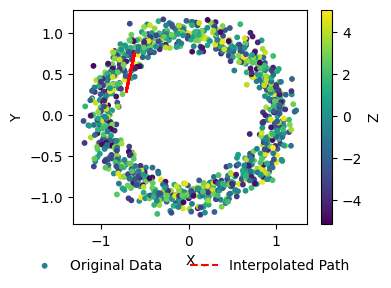

483 94


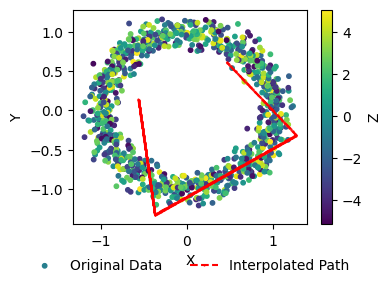

10 358


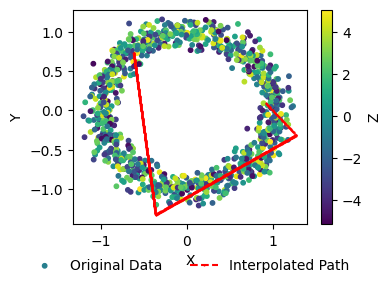

96 215


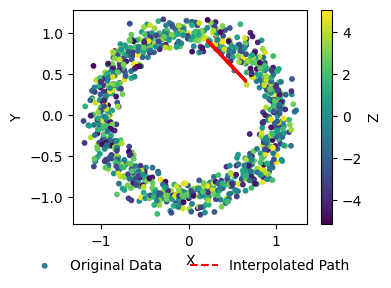

323 30


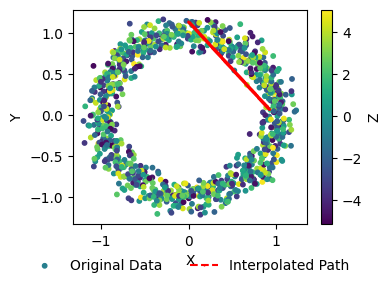

450 166


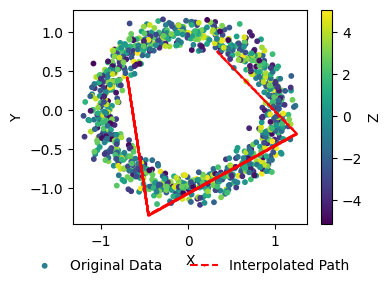

286 428


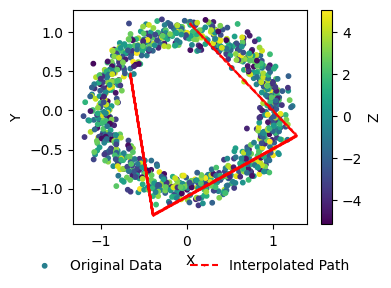

320 217


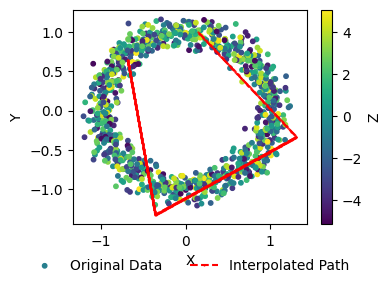

400 98


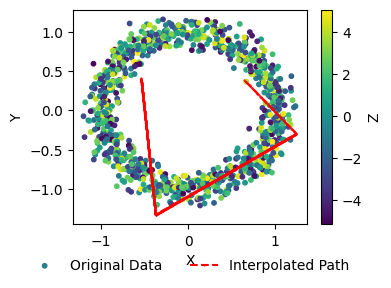

203 113


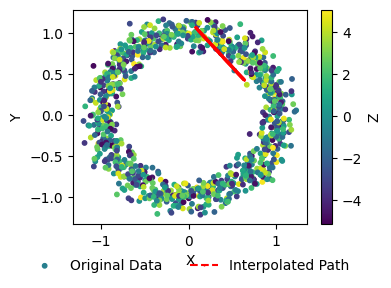

195 415


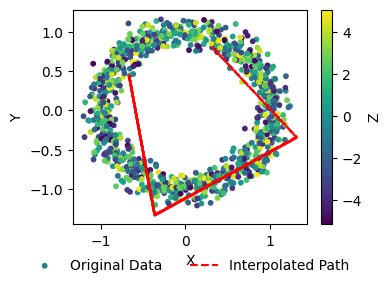

128 279


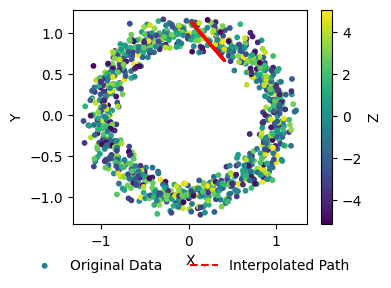

372 108


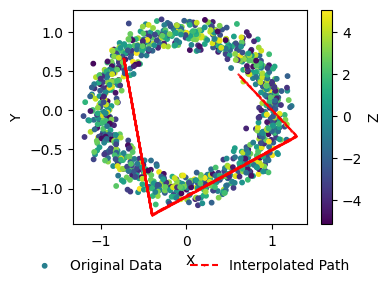

125 467


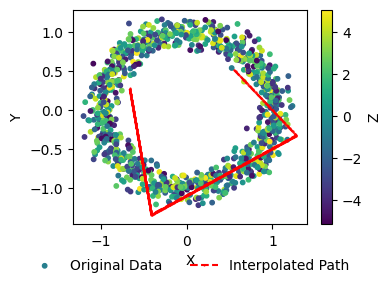

77 345


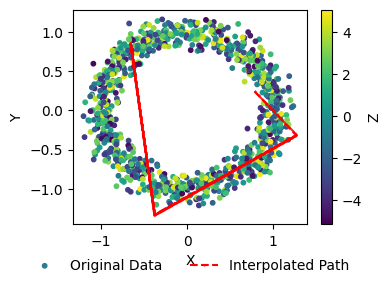

265 380


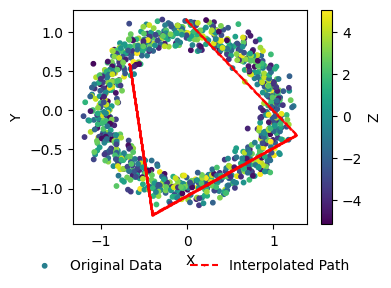

116 27


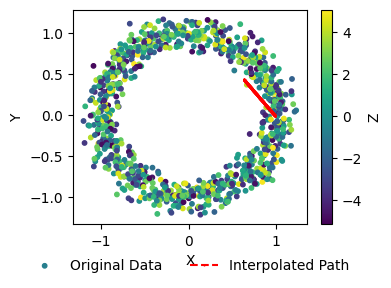

39 346


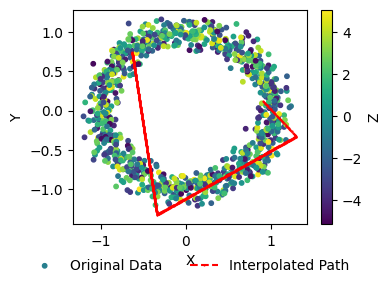

17 203


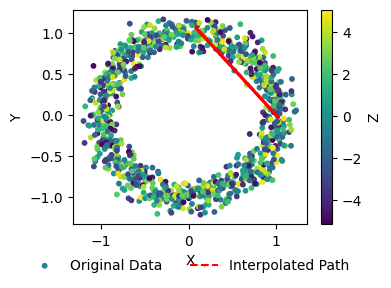

190 293


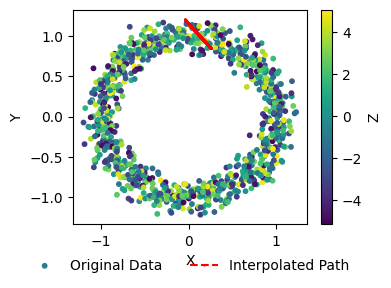

188 171


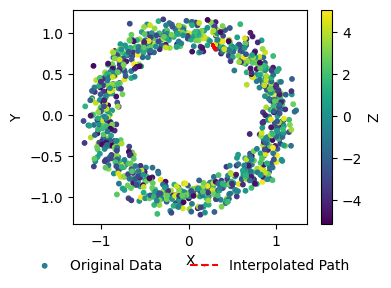

246 297


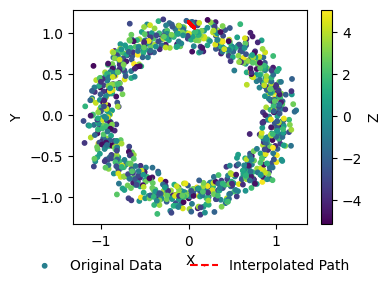

422 400


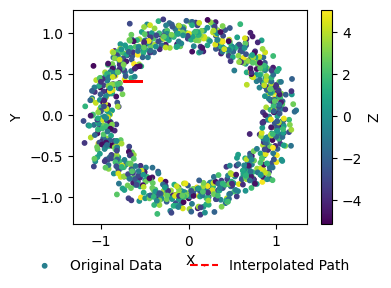

211 366


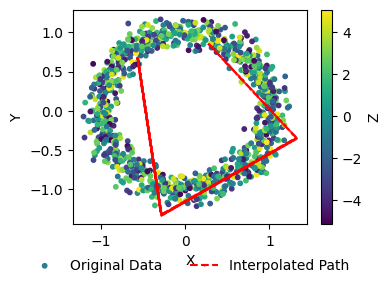

212 344


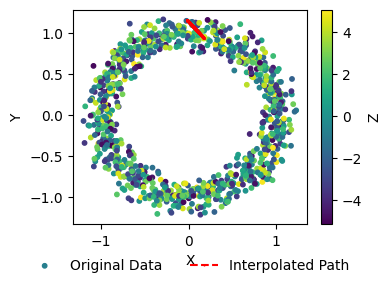

18 321


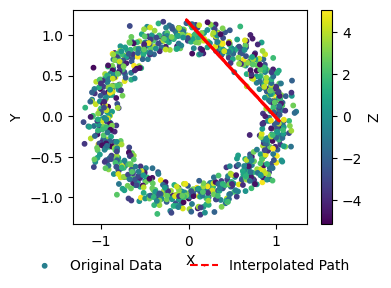

393 398


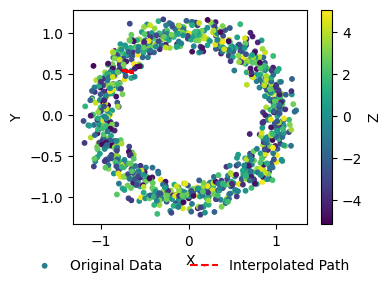

357 253


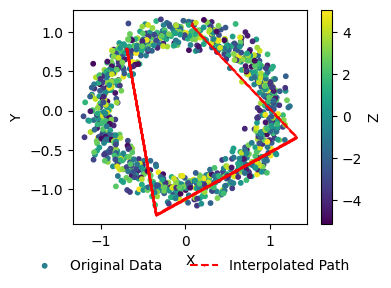

311 30


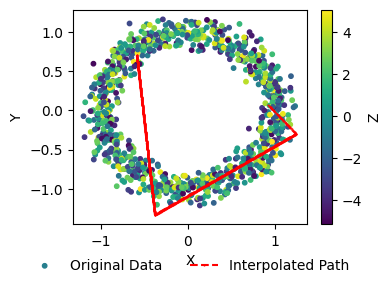

100 135


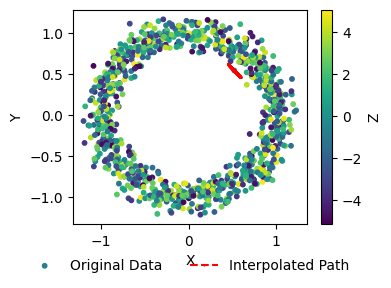

368 338


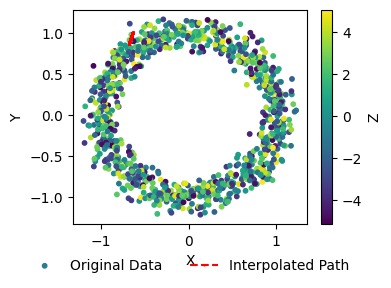

387 405


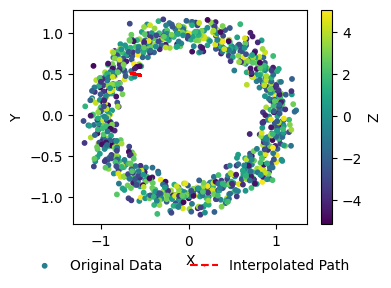

117 253


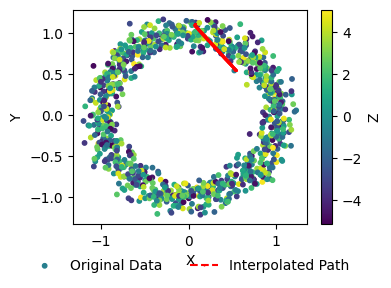

201 113


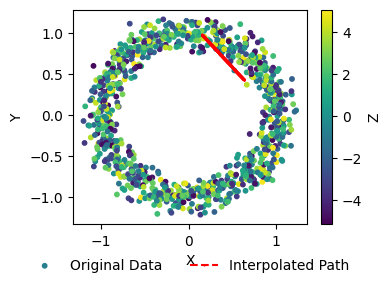

361 150


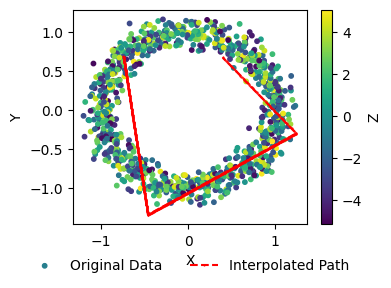

396 242


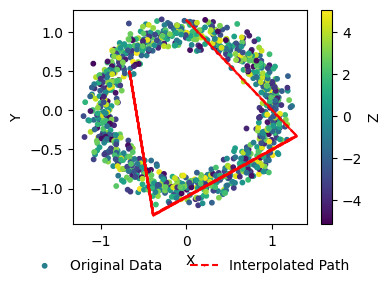

143 218


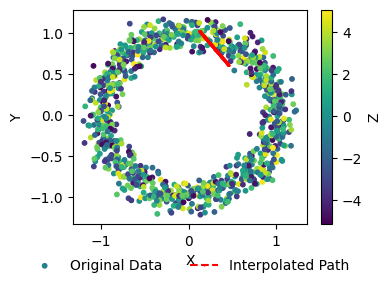

302 242


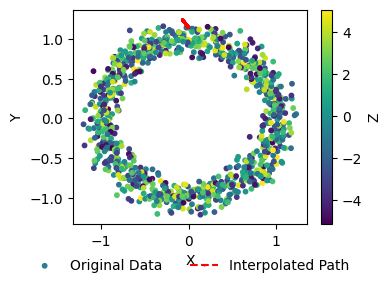

36 29


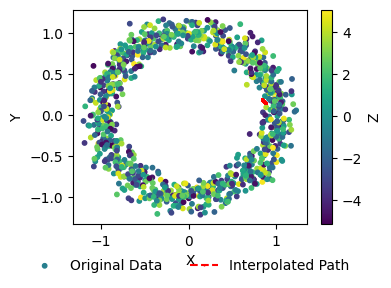

455 484


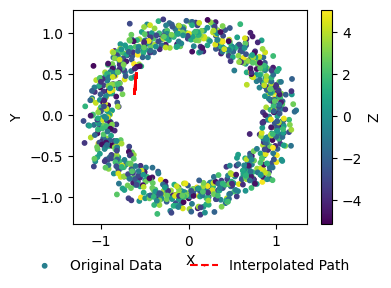

425 371


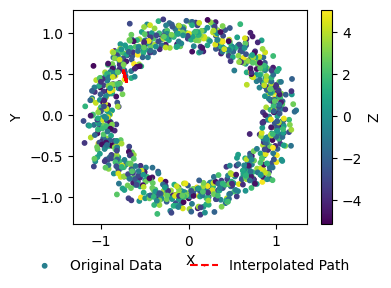

40 330


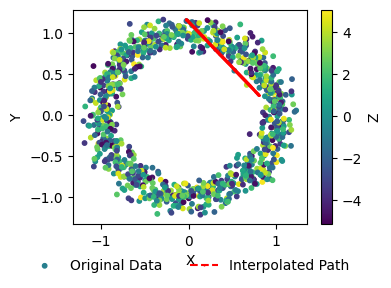

200 315


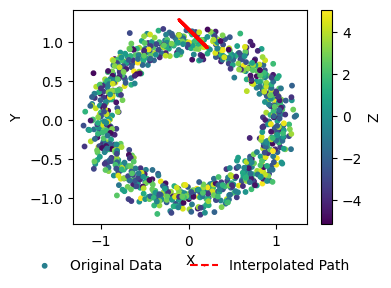

313 129


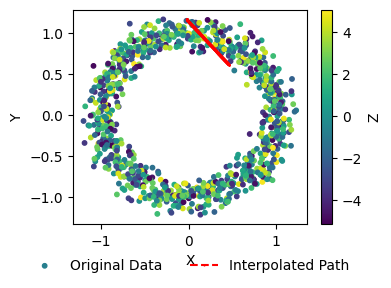

276 225


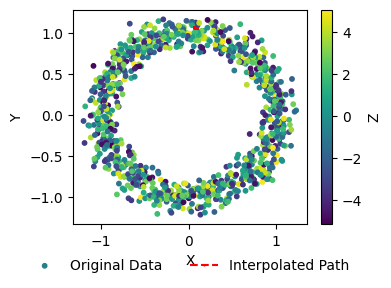

273 497


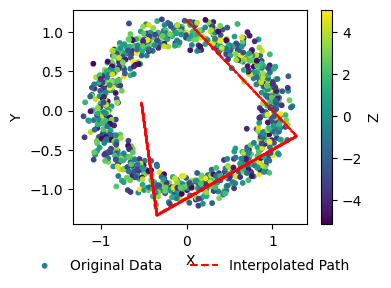

416 228


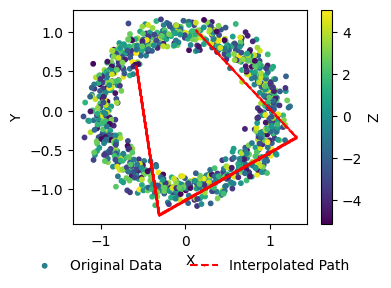

385 342


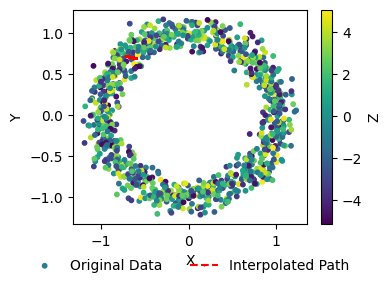

337 290


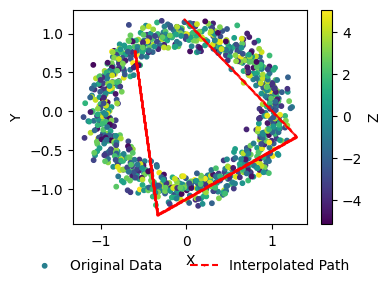

174 40


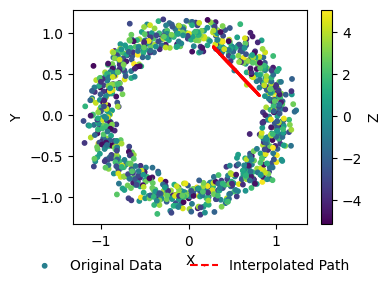

21 320


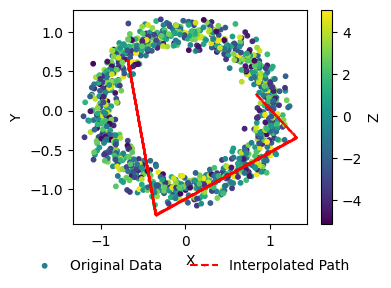

496 88


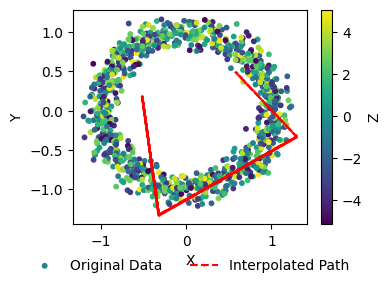

359 146


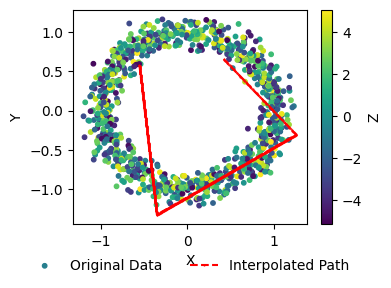

401 50


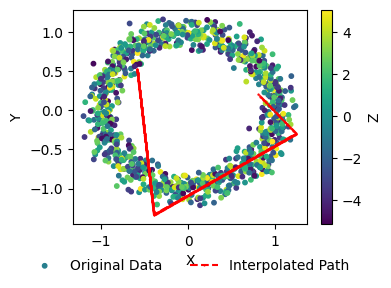

144 31


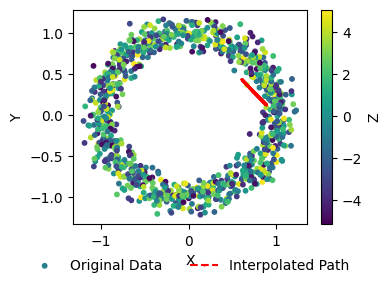

367 147


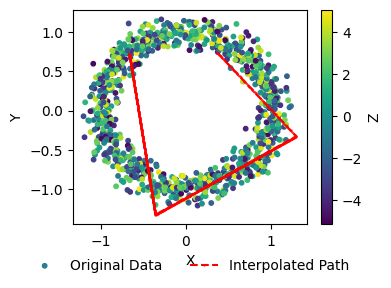

373 463


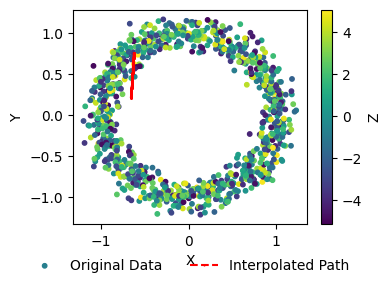

223 296


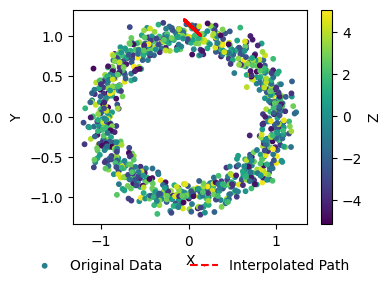

414 309


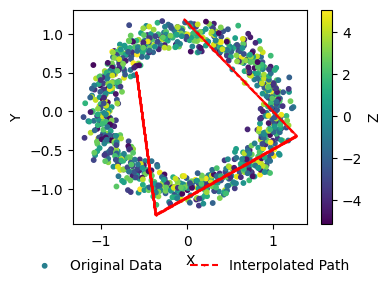

358 193


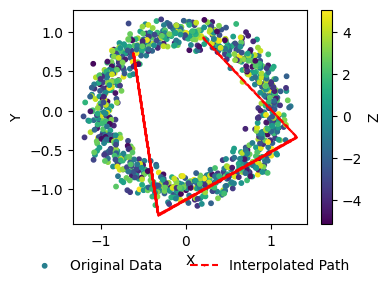

178 468


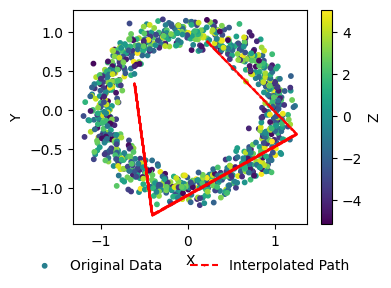

131 382


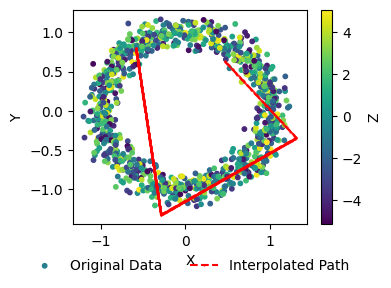

156 143


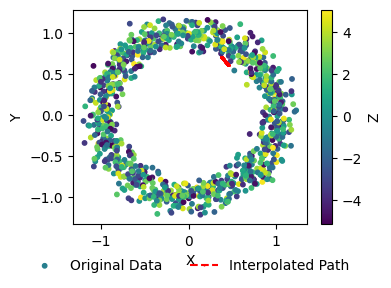

73 297


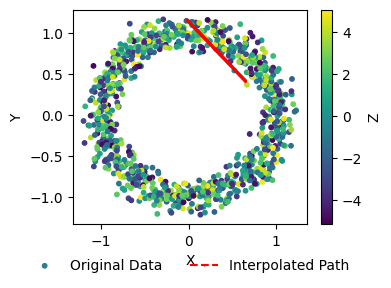

425 179


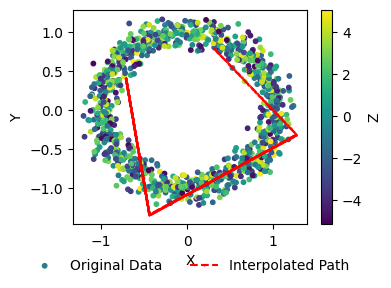

43 64


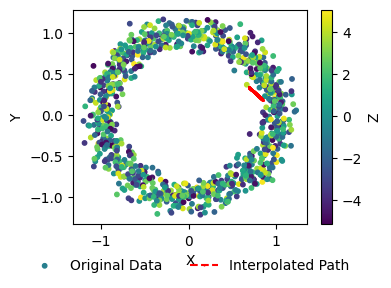

202 303


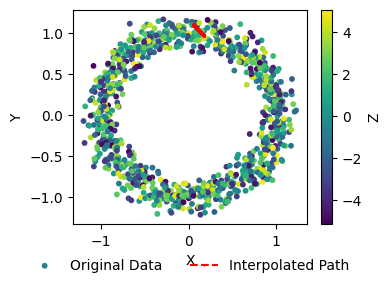

211 29


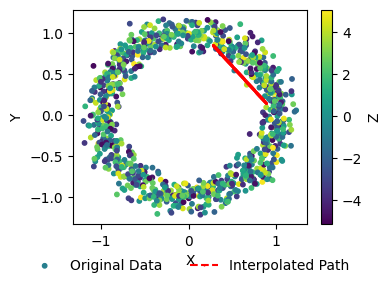

204 53


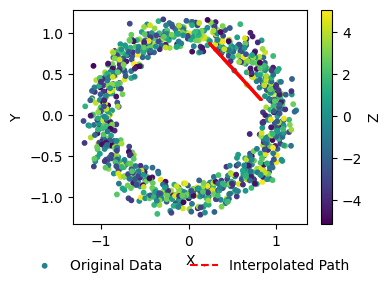

385 473


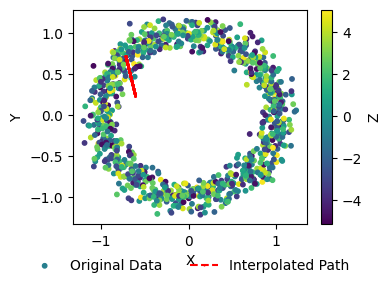

454 291


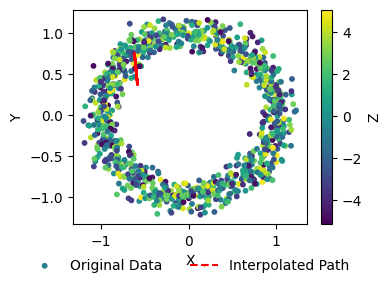

387 491


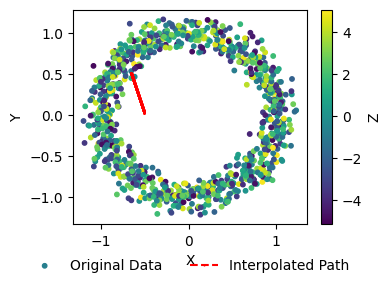

131 262


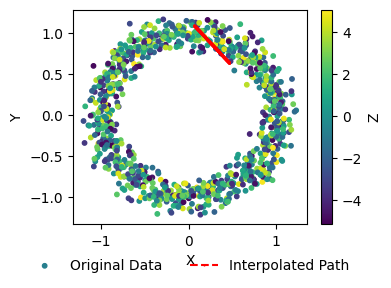

134 87


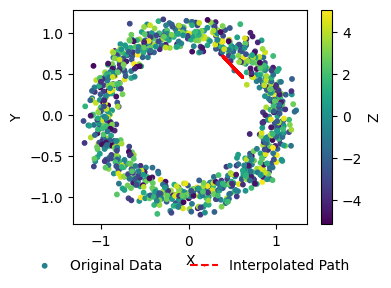

377 492


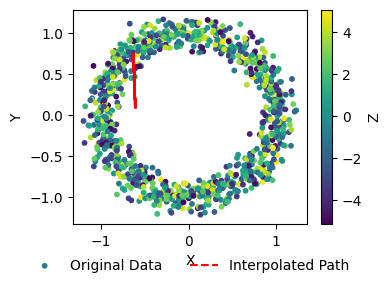

163 60


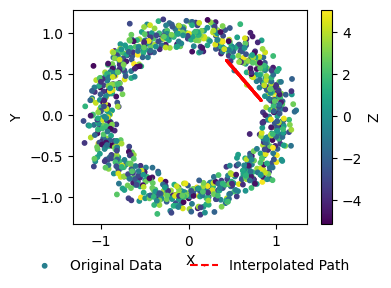

239 115


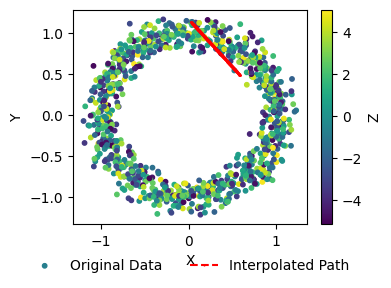

29 76


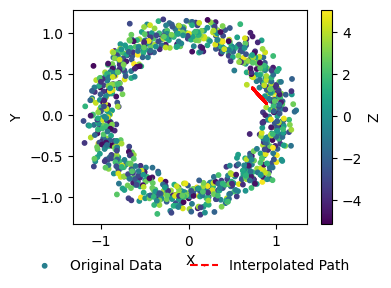

203 297


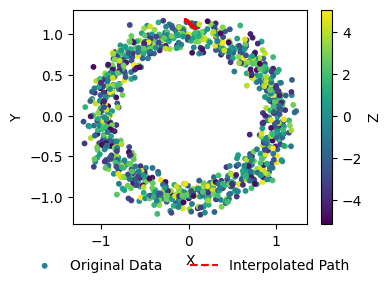

391 169


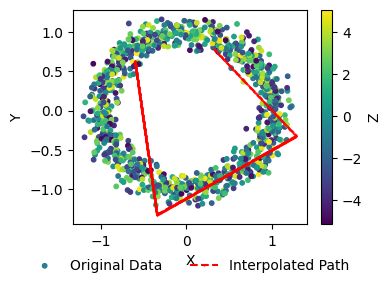

101 31


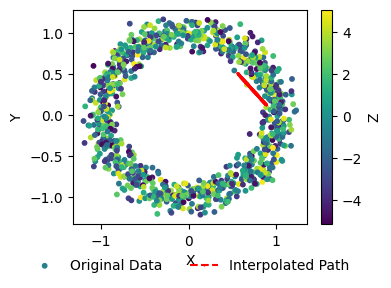

417 14


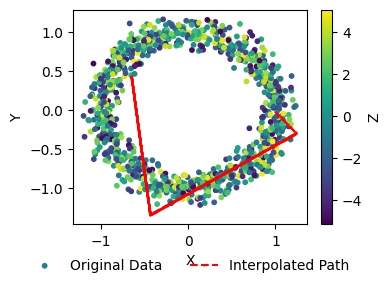

472 243


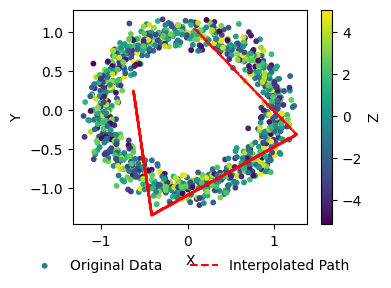

485 90


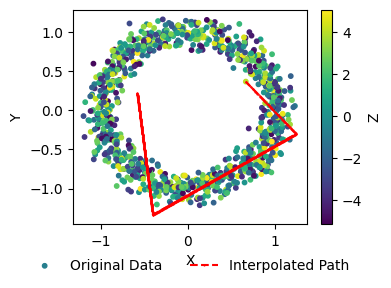

195 138


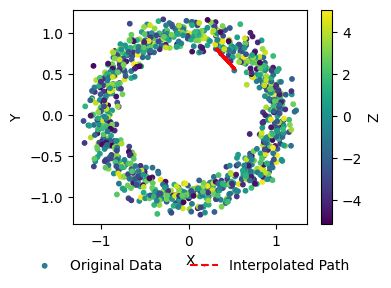

495 460


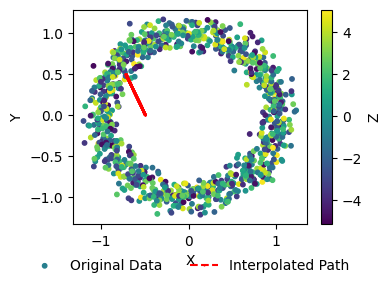

433 403


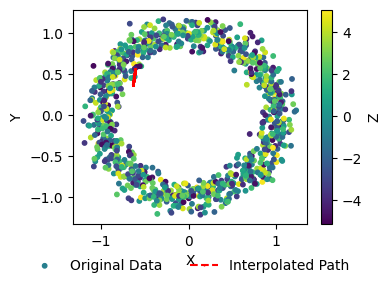

276 252


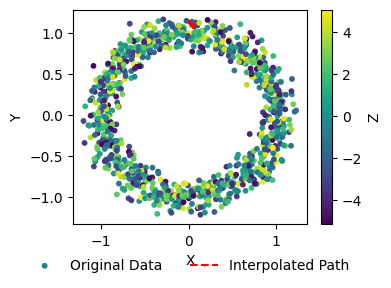

438 103


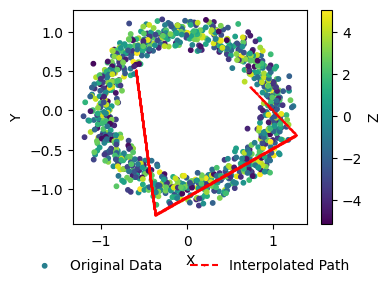

73 198


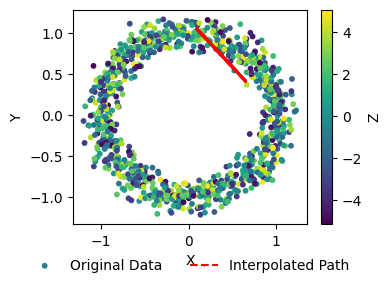

294 35


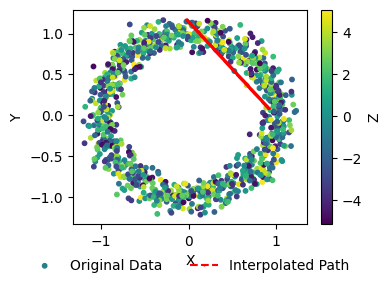

178 436


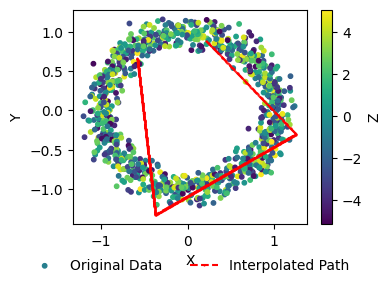

484 297


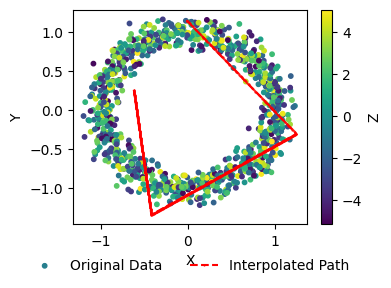

348 226


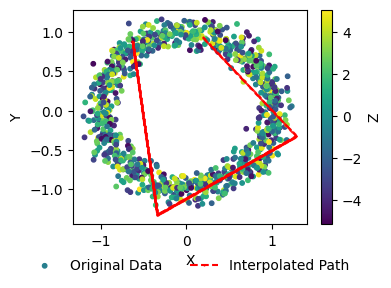

12 83


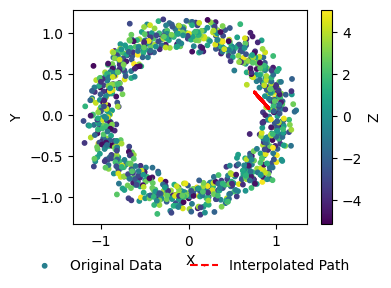

442 412


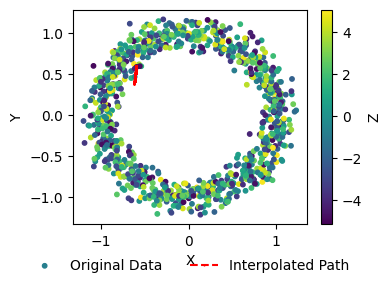

326 42


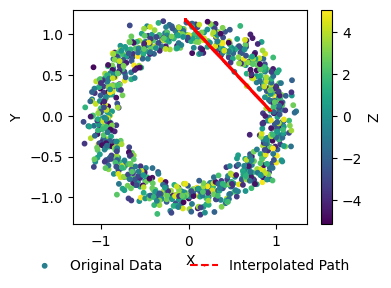

24 4


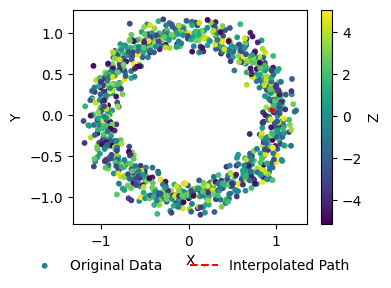

In [79]:
for _ in range(100):
    i = np.random.choice(500)
    j = np.random.choice(500)
    print(i,j)

    num_steps = 1000   # Number of interpolation steps
    
    # Assuming `vae` is the trained VAE model and `swiss_roll` is the dataset
    interpolate_and_decode(vae, i, j, circular_data, num_steps)

Save model 

In [80]:
torch.save(vae.state_dict(), "vae_ckpt/circular/2.ckpt")

In [ ]:
# couples = [(7120, 9155),(6998, 1972), (6439, 9213), (3853, 8585), (5614, 8474), (4781, 2469), (5924, 1078), (5808, 8474)]

## Compare different VAE paths 

In [15]:
vae_0 = VAE(input_dim, latent_dim)
vae_05 = VAE(input_dim, latent_dim)
vae_1 = VAE(input_dim, latent_dim)

In [16]:
vae_0.load_state_dict(torch.load("vae_ckpt/circular/0.ckpt"))
vae_05.load_state_dict(torch.load("vae_ckpt/circular/05.ckpt"))
vae_1.load_state_dict(torch.load("vae_ckpt/circular/1.ckpt"))
# vae_2.load_state_dict(torch.load("vae_ckpt/circular/2.ckpt"))

<All keys matched successfully>

472 118
No reg


AttributeError: 'int' object has no attribute 'write'

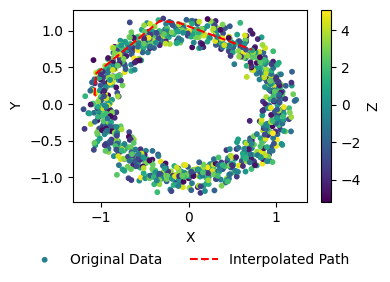

In [19]:
for _ in range(100):
    i = np.random.choice(500)
    j = np.random.choice(500)
    print(i,j)

    num_steps = 100   # Number of interpolation steps
    
    print("No reg")
    interpolate_and_decode(vae_0, i, j, circular_data, 10000)
    print("Lambda 0.5")
    interpolate_and_decode(vae_05, i, j, circular_data, 10000)
    print("Lambda 1")
    interpolate_and_decode(vae_1, i, j, circular_data, 10000)

In [20]:
couples = [(10, 358) ,(323, 30), (450, 166), (400, 98), (128, 279), (77, 345), (116, 27)]

No reg


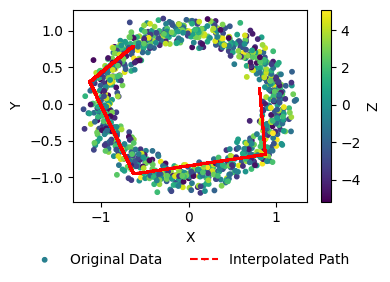

Lambda 0.5


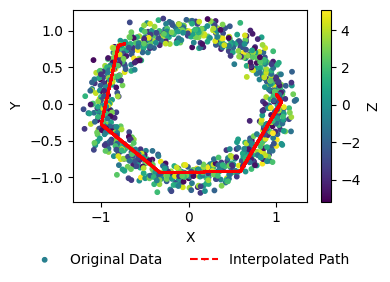

Lambda 1


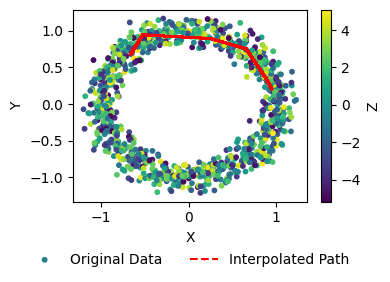

No reg


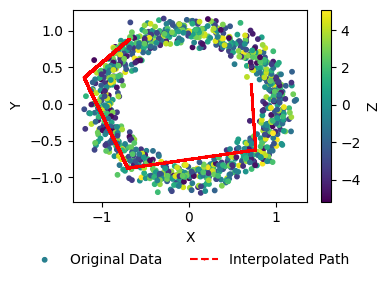

Lambda 0.5


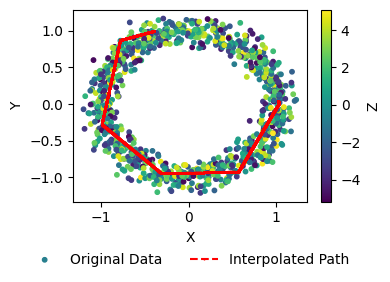

Lambda 1


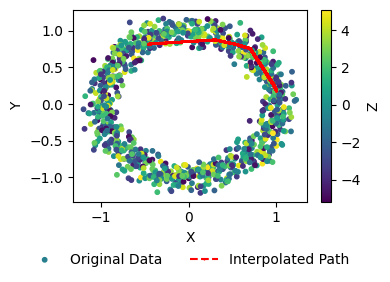

No reg


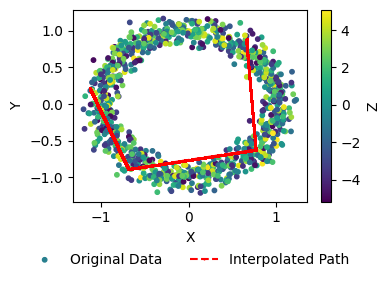

Lambda 0.5


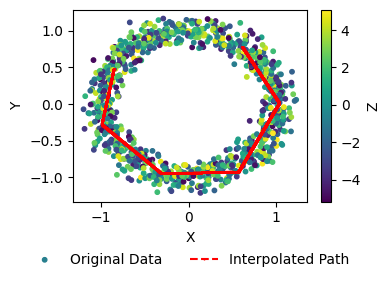

Lambda 1


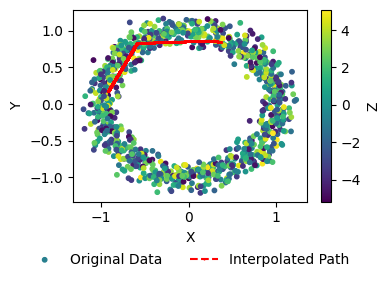

No reg


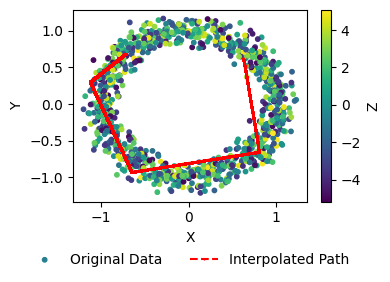

Lambda 0.5


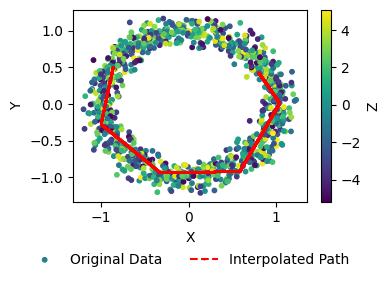

Lambda 1


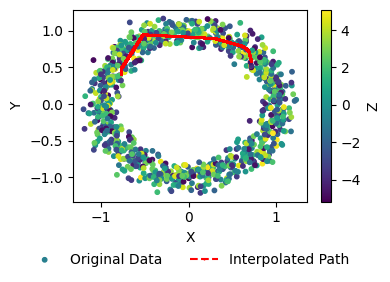

No reg


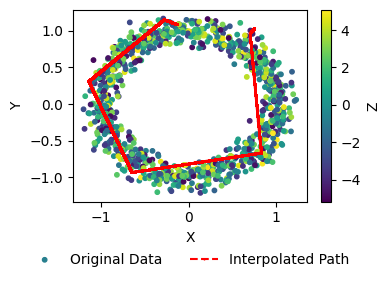

Lambda 0.5


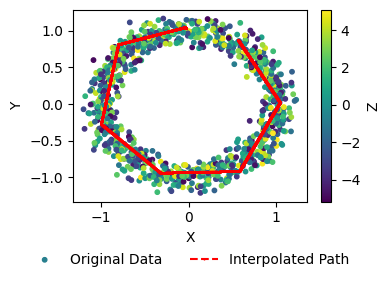

Lambda 1


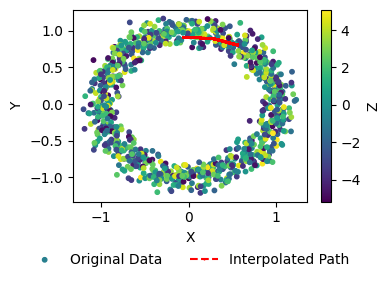

No reg


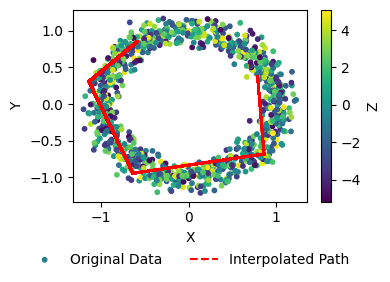

Lambda 0.5


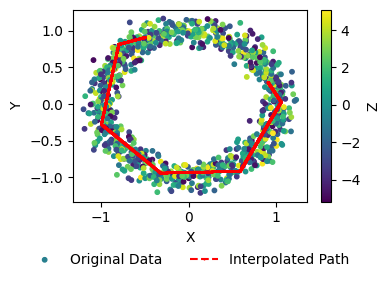

Lambda 1


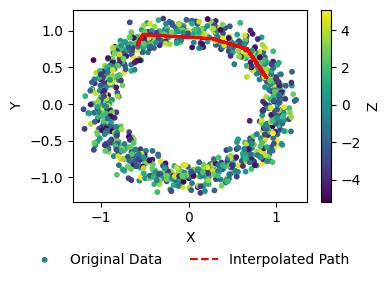

No reg


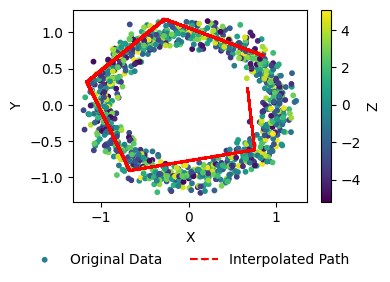

Lambda 0.5


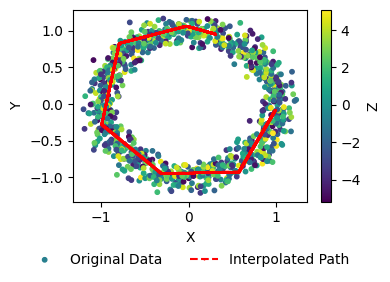

Lambda 1


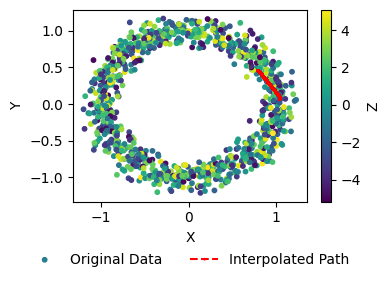

In [23]:
for i,j in couples:
    num_steps = 100   # Number of interpolation steps
    
    print("No reg")
    interpolate_and_decode(vae_0, i, j, circular_data, path=f"figures/circular_plots/{i}_{j}_0.png", num_steps=100000)
    print("Lambda 0.5")
    interpolate_and_decode(vae_05, i, j, circular_data,  path=f"figures/circular_plots/{i}_{j}_1.png", num_steps=10000)
    print("Lambda 1")
    interpolate_and_decode(vae_1, i, j, circular_data,  path=f"figures/circular_plots/{i}_{j}_2.png", num_steps=10000)
    